In [1]:
!nvidia-smi

Sun Jun  4 09:39:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.51.01              Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:09:00.0  On |                  N/A |
| 96%   43C    P3               85W / 350W|   9440MiB / 24576MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image
import pandas as pd
import os

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class Net(nn.Sequential):
    def __init__(self, i):
        out_size = [246016, 57600, 12544, 2304, 256]
        super().__init__(
            nn.Conv2d(3, 32, 3, 1), nn.ReLU(),
            *[layer for _ in range(i) for layer in [nn.Conv2d(32, 32, 3, 1), nn.MaxPool2d(2), nn.Dropout(0.25)]],
            nn.Conv2d(32, 64, 3, 1), nn.MaxPool2d(2), nn.Dropout(0.25),
            Flatten(), nn.Linear(out_size[i], 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2), nn.LogSoftmax(dim=1) )

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx*len(data), len(train_loader.dataset),
        #         100. * batch_idx/len(train_loader), loss.item()))
        losses.append(loss.item())
    return sum(losses)/len(losses)

from sklearn.metrics import recall_score

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            
            # Store predictions and targets for recall calculation
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    recalls = recall_score(all_targets, all_preds, average=None)  # compute recall for each class
    class_recall = recalls[1]  # replace 0 with the index of the class you're interested in

    # print('\nTest set: Average loss: {:.4f}, Recall: {:.2f}\n'.format(
    #     test_loss/len(test_loader.dataset), class_recall))

    return class_recall

In [5]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.data_info = self.get_img_info(data_dir)
        self.transforms = transforms

    def __getitem__(self, item):
        path_img, label = self.data_info.iloc[item][1:3]
        label = int(label)
        path_img = os.path.join(self.data_dir, path_img)
        image = Image.open(path_img).convert('RGB') # Gray scale is enough for logic interpretation
        # 使用定义好的transforms，对数据进行处理
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.data_info)
    
    def get_img_info(self, data_dir):
        path_dir = os.path.join(data_dir, 'label.csv')
        return pd.read_csv(path_dir)

In [6]:
dataset_folder = "dataset03"
exp_name = f"{dataset_folder}_ablation_study"

if not os.path.exists(f'./models/{exp_name}'):
    os.mkdir(f'./models/{exp_name}')

In [7]:
kwargs = {'num_workers': 16}
batch_size=128

InDL = True
if InDL:
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

    trainset = MyDataset(f"data/train/{dataset_folder}", transform)
    testset = MyDataset(f"data/test/{dataset_folder}", transform)
else:
    transform=transforms.Compose(
        [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

    trainset = datasets.MNIST(root='data/mnist', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='data/mnist', train=False, download=True, transform=transform)
    
    # trainset = datasets.CIFAR10(root='data/cifar10', train=True, download=True, transform=transform)
    # testset = datasets.CIFAR10(root='data/cifar10', train=False, download=True, transform=transform)
    

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, **kwargs)

100%|██████████| 100/100 [08:07<00:00,  4.88s/it]


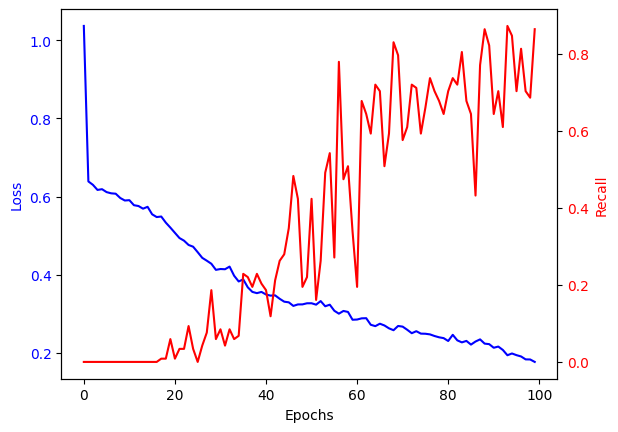

100%|██████████| 100/100 [07:15<00:00,  4.36s/it]


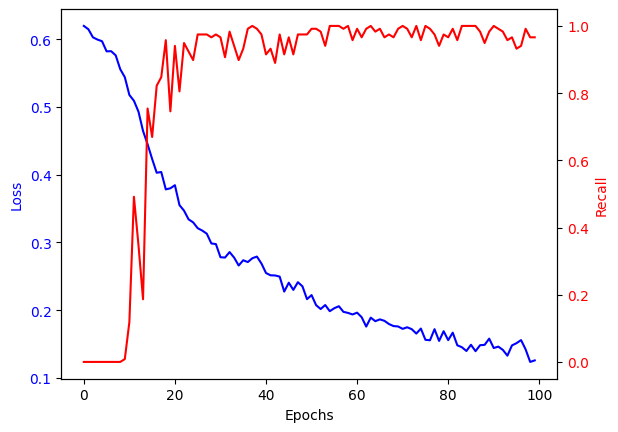

 20%|██        | 20/100 [01:55<07:30,  5.63s/it]

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

epochs, lr = 100, 1e-4

for i in range(5):
    df = pd.DataFrame(columns=['Loss', 'Recall'])
    
    model_name = f"{i}-net"
    if InDL:
        model_name = f"{model_name}-InDL"
    else:
        model_name = f"{model_name}-MNIST"

    model = Net(i).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    model_path = f'./models/{exp_name}/{model_name}.pt'
    history_path = f'./models/{exp_name}/{model_name}_history.csv'

    if os.path.exists(history_path):
        df = pd.read_csv(history_path)
    else:
        previous_best_recall = 0
        for epoch in tqdm(range(1, epochs+1)):
            loss = train(model, device, train_loader, optimizer, epoch)
            recall = test(model, device, test_loader)
            
            df.loc[len(df)] = [loss, recall]
            
            if recall > previous_best_recall:
                previous_best_recall = recall
                torch.save(model.state_dict(), model_path)
                
        df.to_csv(history_path, index=False)

    # Assuming df is your DataFrame and it has columns 'Loss' and 'Class 0 Recall'

    fig, ax1 = plt.subplots()

    # Plot Loss
    sns.lineplot(data=df, x=df.index, y='Loss', ax=ax1, color='blue')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis and plot Recall on it
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x=df.index, y='Recall', ax=ax2, color='red')
    ax2.set_ylabel('Recall', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax1.set_xlabel('Epochs')

    plt.show()  

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, device):
    model.eval()  # set the model to evaluation mode
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():  # don't calculate gradients
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_predictions))

for i in range(5):
    model_name = f"{i}-net"
    if InDL:
        model_name = f"{model_name}-InDL"
    else:
        model_name = f"{model_name}-MNIST"
        
    state_dict = torch.load(f"models/{exp_name}/{model_name}.pt")
    model = Net(i).to(device)
    model.load_state_dict(state_dict)
    
    print(model_name)

    # Assuming you have a model, dataloader and device (CPU or CUDA) defined
    evaluate_model(model, test_loader, device)

FileNotFoundError: [Errno 2] No such file or directory: 'models/dataset03_ablation_study/0-net-InDL.pt'